## 1.GBDT算法
GBDT（Gradient Boosting Decision Tree），全名叫梯度提升决策树，是一种迭代的决策树算法，又叫 MART（Multiple Additive Regression Tree），它通过构造一组弱的学习器（树），并把多颗决策树的结果累加起来作为最终的预测输出。该算法将决策树与集成思想进行了有效的结合。

GBDT中的树是回归树（不是分类树），GBDT用来做回归预测，调整后也可以用于分类。

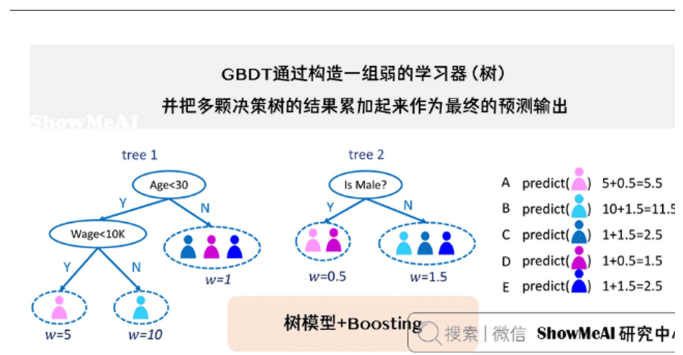

### 1.1 应用场景
- 1、用于自动挖掘有效特征、特征组合

- 2、作为LR模型中的特征，提高CTR预估

- 3、GBDT应用于淘宝的搜索及预测业务

### 1.2 Boosting核心思想
Boosting方法训练基分类器时采用串行的方式，各个基分类器之间有依赖。它的基本思路是将基分类器层层叠加，每一层在训练的时候，对前一层基分类器分错的样本，给予更高的权重。测试时，根据各层分类器的结果的加权得到最终结果。

Bagging 与 Boosting 的串行训练方式不同，Bagging 方法在训练过程中，各基分类器之间无强依赖，可以进行并行训练。

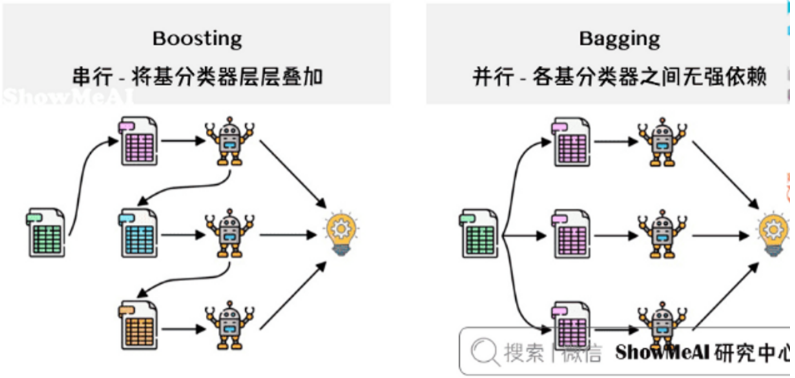



## 2、GBDT详解
### GBDT的原理

- 所有弱分类器的结果相加等于预测值。
- 每次都以当前预测为基准，下一个弱分类器去拟合误差函数对预测值的残差（预测值与真实值之间的误差）。
- GBDT的弱分类器使用的是树模型(cart)。

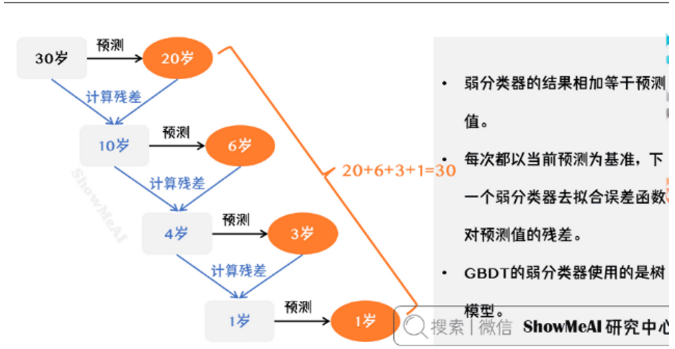

如图是一个非常简单的帮助理解的示例，我们用 GBDT 去预测年龄：

- 第一个弱分类器（第一棵树）预测一个年龄（如20岁），计算发现误差有10岁；
- 第二棵树预测拟合残差，预测值 6，计算发现差距还有 4 岁；
- 第三棵树继续预测拟合残差，预测值 3，发现差距只有 1 岁了；
- 第四课树用  1 岁拟合剩下的残差，完成。

最终，四棵树的结论加起来，得到30岁这个标注答案（实际工程实现里，GBDT 是计算负梯度，用负梯度近似残差）

### GBDT计算流程
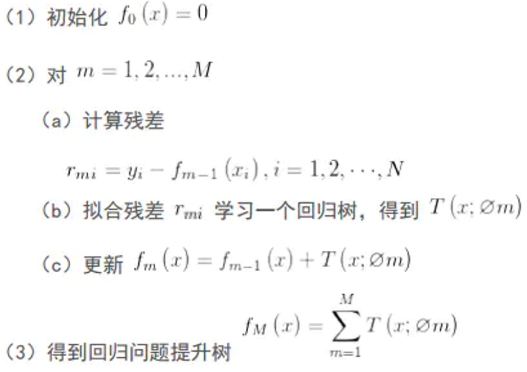

### 1、GBDT与负梯度近似残差
回归任务下，GBDT在每一轮的迭代时对每个样本都会有一个预测值，此时的损失函数为均方差损失函数：
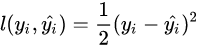
损失函数的负梯度计算如下：
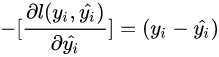

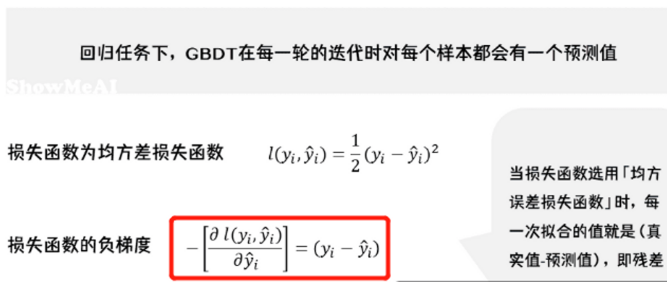
可以看出，当损失函数选用「均方误差损失」时，每一次拟合的值就是（真实值-预测值），即残差。

### 2、GBDT训练过程
我们来借助1个简单的例子理解一下 GBDT 的训练过程。假定训练集只有4个人（A、B、C、D），他们的年龄分别是（14,16,24,26）。其中，A、B分别是高一和高三学生；C、D分别是应届毕业生和工作两年的员工。

我们先看看用回归树来训练，得到的结果如下图所示：

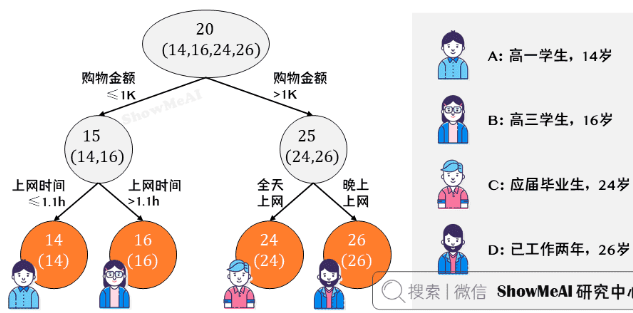

接下来改用 GBDT 来训练。由于样本数据少，我们限定叶子节点最多为2（即每棵树都只有一个分枝），并且限定树的棵树为2。
最终训练得到的结果如下图所示：
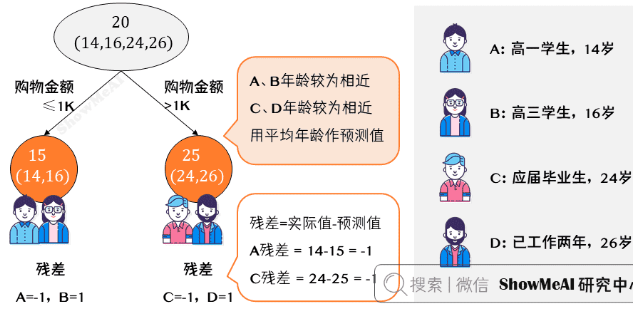

上图中的树很好理解：A、B年龄较为相近，C、D年龄较为相近，被分为左右两支，每支用平均年龄作为预测值。

- 我们计算残差（即「实际值」-「预测值」），所以 A  的残差 14-15=-1 。
- 这里 A的「预测值」是指前面所有树预测结果累加的和，在当前情形下前序只有一棵树，所以直接是15 ，其他多树的复杂场景下需要累加计算作为 A 的预测值。

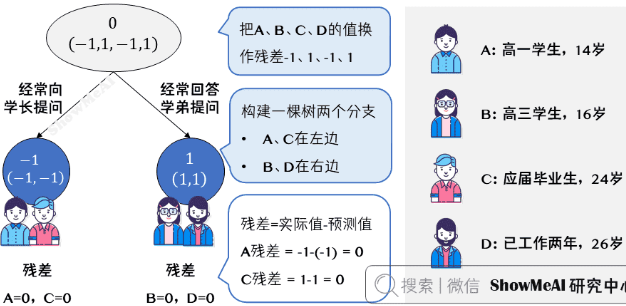

上图中的树就是残差学习的过程了：

- 把 A、B、C、D 的值换作残差 -1、1、-1、1，再构建一棵树学习，这棵树只有两个值 1 和 -1，直接分成两个节点：A、C 在左边，B、D在右边。
- 这棵树学习残差，在我们当前这个简单的场景下，已经能保证预测值和实际值（上一轮残差）相等了。
- 我们把这棵树的预测值累加到第一棵树上的预测结果上，就能得到真实年龄，这个简单例子中每个人都完美匹配，得到了真实的预测值。

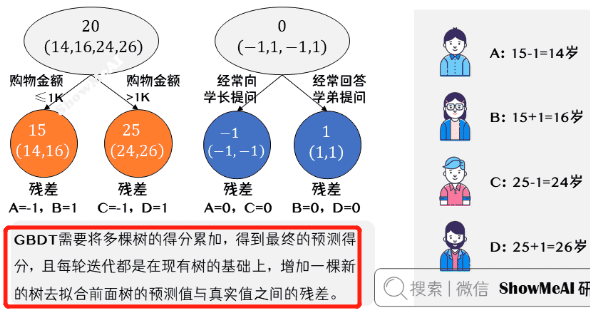
最终的预测过程是这样的：

- A：高一学生，购物较少，经常问学长问题，真实年龄 14 岁，预测年龄A=15-1=14
- B：高三学生，购物较少，经常被学弟提问，真实年龄 16 岁，预测年龄B=15+1=16
- C：应届毕业生，购物较多，经常问学长问题，真实年龄 24 岁，预测年龄C=25-1=24
- D：工作两年员工，购物较多，经常被学弟提问，真实年龄 26 岁，预测年龄D=25+1=26

综上，GBDT 需要将多棵树的得分累加得到最终的预测得分，且每轮迭代，都是在现有树的基础上，增加一棵新的树去拟合前面树的预测值与真实值之间的残差。

### 3.梯度提升 vs 梯度下降
下面我们来对比一下「梯度提升」与「梯度下降」。这两种迭代优化算法，都是在每1轮迭代中，利用损失函数负梯度方向的信息，更新当前模型，只不过：

- **梯度下降**中，模型是以参数化形式表示，从而模型的更新等价于参数的更新。

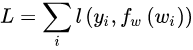

- **梯度提升**中，模型并不需要进行参数化表示，而是直接定义在函数空间中，从而大大扩展了可以使用的模型种类。

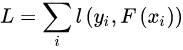

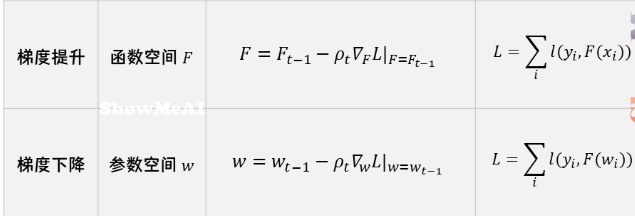

## 3.GBDT优缺点

### **1）优点**

- 预测阶段，因为每棵树的结构都已确定，计算速度快。
- 适用稠密数据，泛化能力和表达能力都不错，数据科学竞赛榜首常见模型。
- 可解释性不错，鲁棒性亦可，能够自动发现特征间的高阶关系。

### **2）缺点**

- GBDT 在高维稀疏的数据集上，效率较差，且效果表现不如 SVM 或神经网络。
- 适合数值型特征，在 NLP 或文本特征上表现弱。
- 训练过程无法并行，工程加速只能体现在单颗树构建过程中。

## ****4.随机森林 vs GBDT****

### **1）相同点**

- 都是集成模型，由多棵树组构成，最终的结果都是由多棵树一起决定。
- **RF** 和 **GBDT** 在使用 **CART** 树时，可以是分类树或者回归树。

### **2）不同点**

- 训练过程中，随机森林的树可以并行生成，而 **GBDT** 只能串行生成。
- 随机森林的结果是多数表决表决的，而 **GBDT** 则是多棵树累加之。
- 随机森林对异常值不敏感，而 **GBDT** 对异常值比较敏感。
- 随机森林降低模型的方差，而 **GBDT** 是降低模型的偏差。

## 代码演示-GBDT
- 数据集 随机生成
- sklearn
- 可视化决策树插件 Download：https://graphviz.org/download/
- 决策树插件安装文档：https://blog.csdn.net/u012744245/article/details/103360769

In [8]:
## 使用Sklearn调用GBDT模型拟合数据并可视化
import numpy as np
import pydotplus
import os
from sklearn.ensemble import GradientBoostingRegressor
os.environ["PATH"]+=os.pathsep+'C:/Program Files/Graphviz/bin/' #指定路径
import sklearn
sklearn.__version__


'0.24.2'

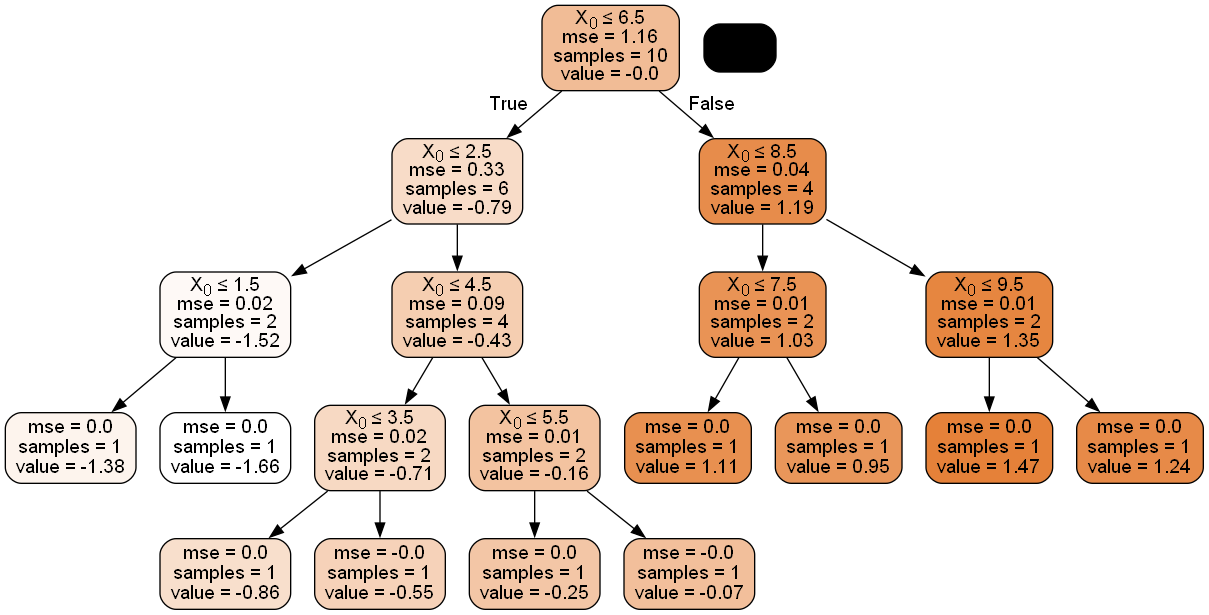

In [9]:
X = np.arange(1, 11).reshape(-1, 1)
y = np.array([5.16, 4.73, 5.95, 6.42, 6.88, 7.15, 8.95, 8.71, 9.50, 9.15])

gbdt = GradientBoostingRegressor(max_depth=4, criterion ='mse').fit(X, y)
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

## 拟合训练5棵树
sub_tree = gbdt.estimators_[4, 0]
dot_data = export_graphviz(sub_tree, out_file=None, filled=True, rounded=True, special_characters=True, precision=2)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())